# 서대문구 공공자전거 수요불균형 근처 대여소 추가 분석

[ 목적 ]
- 서대문구의 우선 개선 대상으로 선정한 대여소 근처에서 우선 개선 대상 대여소(수요 불균형 대여소)에 출퇴근 시간에 자전거 수급이 가능한 대여소가 존재하는지 확인하기 위한 분석 진행

[목차]
1. 분석 환경 조성
    - 1)라이브러리 호출 및 폰트 설정
    - 2)데이터 프레임 생성
2. 수요 불균형 근처 대여소 선별
    - 1)자치구 필터링
    - 2)분석할 대여소 선별
3. 데이터 시각화
4. 결론

[ 데이터 설명 ]

| **컬럼명** | **설명** | **비고** |
|----------|----------|----------|
| 일시    | 거치대 수량이 집계된 날짜   | *년-월-일*  |
| 대여소 번호    | 대여소 번호   |   |
| 보관소(대여소)명    | 보관소(대여소) 이름  |    |
| 시간대    | 거치대 수량이 집계된 시간대   | *0시 ~ 23시*  |
| 거치대수량    | 해당 시간대에 대여 가능한 자전거 수   |   |
| 자치구    | 대여소가 속한 자치구  |   |
|거치대수    | 대여소에 설치된 거치대 수  | *대여소의 기본 자전거 수량*  |


- 수요 지수 : (거치대 수 - 대여 가능 자전거 수) / (거치대 수)
    - 기본 자전거 수량 대비 얼마나 많은 자전거가 이용 중인가를 나타내는 지수

---
---

### 분석 환경 조성

#### 1) 라이브러리 호출 및 폰트 설정

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from folium.plugins import HeatMap
import os
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# 한글 폰트 설정
plt.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] =False

# Pandas 보기 옵션 지정
pd.set_option('display.max_columns',100)

#### 2) 데이터 프레임 생성

In [ ]:
# 데이터 프레임생성
df = pd.read_csv("선별자치구_자치구별_대여가능자전거_거치대수.csv", encoding='CP949')
df.head(3)

,Unnamed: 0,일시,대여소 번호,보관소(대여소)명,시간대,거치대수량,자치구,거치대수
0,10,2023-01-01,115,115. 마스타 빌딩 앞,0,13,서대문구,15
1,11,2023-01-01,117,117. 홍은사거리,0,11,서대문구,23
2,17,2023-01-01,123,123. 문화촌 공원,0,13,서대문구,20


In [ ]:
# 'Unnamed: 0' 컬럼 삭제
df = df.drop(columns='Unnamed: 0')

In [ ]:
df.head(3)

,일시,대여소 번호,보관소(대여소)명,시간대,거치대수량,자치구,거치대수
0,2023-01-01,115,115. 마스타 빌딩 앞,0,13,서대문구,15
1,2023-01-01,117,117. 홍은사거리,0,11,서대문구,23
2,2023-01-01,123,123. 문화촌 공원,0,13,서대문구,20


### 수요 불균형 대여소 근처 대여소 선별

#### 1) 자치구 필터링

In [ ]:
# 서대문구만 선별
region_df = df[df['자치구'] == '서대문구']
region_df.head(3)

,일시,대여소 번호,보관소(대여소)명,시간대,거치대수량,자치구,거치대수
0,2023-01-01,115,115. 마스타 빌딩 앞,0,13,서대문구,15
1,2023-01-01,117,117. 홍은사거리,0,11,서대문구,23
2,2023-01-01,123,123. 문화촌 공원,0,13,서대문구,20


In [ ]:
# (참고)자치구 평균 거치대수량, 거치대수
region_df.groupby('자치구').mean(numeric_only=True)

,대여소 번호,시간대,거치대수량,거치대수
자치구,,,,
서대문구,1862.583343,11.492893,7.303207,12.050333


- 서대문구의 평균 거치대 수량 : 약 7.3대
- 서대문구의 평균 거치대 수 : 약 12 대

In [ ]:
# 원하는 컬럼만 남기기
tmp = region_df.groupby(['보관소(대여소)명','시간대']).mean(numeric_only=True)[['거치대수량','거치대수']]
tmp.head(3)

거치대수량  거치대수
보관소(대여소)명     시간대                
115. 마스타 빌딩 앞 0    5.745163  15.0
              1    5.241493  15.0
              2    5.009465  15.0

- 이전 자치구 선별을 위한 EDA과정에서 데이터 전처리 과정을 거쳤으므로, 여기서는 전처리 과정을 따로 거치지 않는다.

#### 2) 분석할 대여소 선별
- 이전에 선정한 우선 개선 대여소 기준 반경 1km이내 + 거치대수가 10이상인 대여소를 세부적으로 분석한다.

In [ ]:
# 서대문구 내 수요지수 TOP10 대여소 선별
tmp = region_df.groupby(['보관소(대여소)명']).mean(numeric_only=True)[['거치대수량','거치대수']]
tmp['수요지수'] = (tmp['거치대수'] - tmp['거치대수량'])/tmp['거치대수']

In [ ]:
tmp.head(3)

,거치대수량,거치대수,수요지수
보관소(대여소)명,,,
115. 마스타 빌딩 앞,7.085693,15.0,0.527620
117. 홍은사거리,9.953487,23.0,0.567240
123. 문화촌 공원,16.161671,20.0,0.191916


In [ ]:
# 우선 개선 대상 대여소 근처 대여소 선별
select_df = tmp[tmp.index.isin(['4272. 홍남교 사거리', '3125.연희파크푸르지오아파트 앞',
                '175. 홍연2교옆', '3217.홍은2파출소 옆'])]
select_df

,거치대수량,거치대수,수요지수
보관소(대여소)명,,,
175. 홍연2교옆,8.727705,20.0,0.563615
3125.연희파크푸르지오아파트 앞,15.063206,20.0,0.246840
4272. 홍남교 사거리,12.373381,7.0,-0.767626


In [ ]:
# 선별한 대여소 막대그래프 그리기 위해 인덱스 초기화 후 데이터 프레임 생성
tmp2 = region_df.groupby(['보관소(대여소)명','시간대']).mean(numeric_only=True)[['거치대수량','거치대수']]
tmp3 = tmp2.reset_index()
tmp4 = tmp3[tmp3['보관소(대여소)명'].isin(['4272. 홍남교 사거리', '3125.연희파크푸르지오아파트 앞', '175. 홍연2교옆', '3217.홍은2파출소 옆'])]

In [ ]:
tmp4.head(3)

,보관소(대여소)명,시간대,거치대수량,거치대수
624,175. 홍연2교옆,0,10.240208,20.0
625,175. 홍연2교옆,1,10.949905,20.0
626,175. 홍연2교옆,2,11.769049,20.0


- '3217.홍은2파출소 옆' 대여소는 2023년 데이터에 존재 X, 2024년에 신설된 대여소

In [ ]:
# 선별한 대여소 데이터 프레임에 잘 들어갔는지 확인
tmp4.groupby('보관소(대여소)명').sum().index

Index(['175. 홍연2교옆', '3125.연희파크푸르지오아파트 앞', '4272. 홍남교 사거리'], dtype='object', name='보관소(대여소)명')

---

### 데이터 시각화

- 선별된 대여소에서 시간대별 대여 가능 자전거 수량의 변화 추이를 확인하여 출퇴근시간에 서대문구청, 무악재 4번출구 대여소 / 신규 대여소에 자전거를 수급할 수 있는지 확인한다.

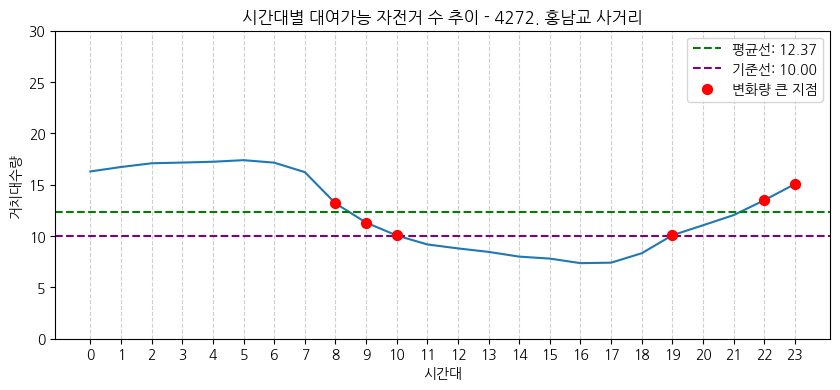

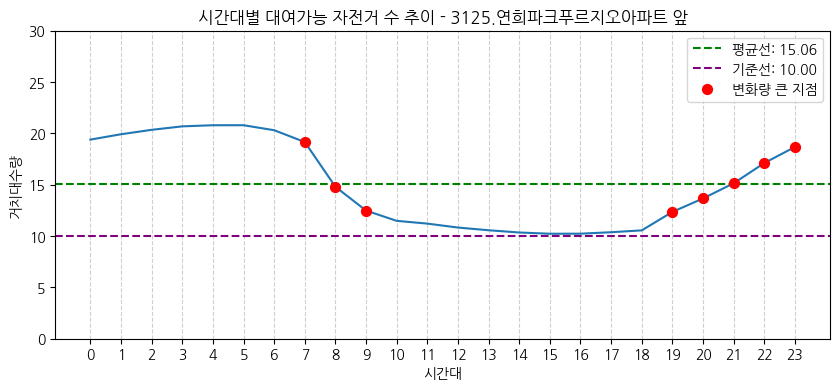

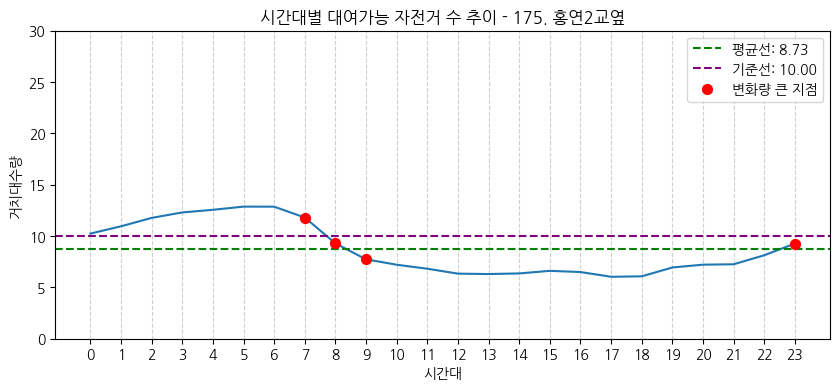

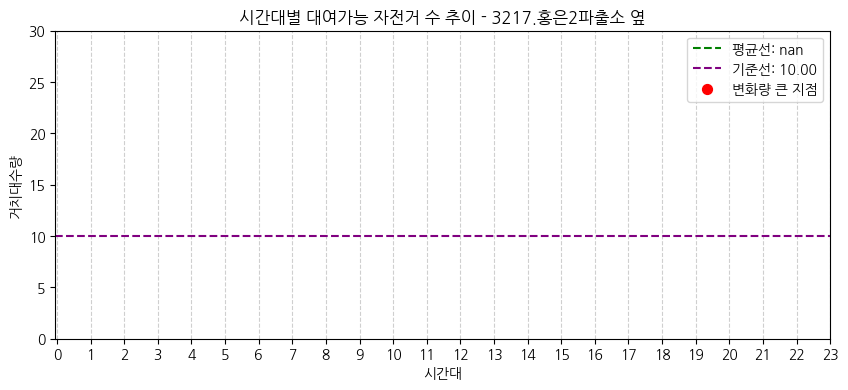

In [ ]:
#수요지수 TOP 10 대여소 시각화
places = ['4272. 홍남교 사거리', '3125.연희파크푸르지오아파트 앞',
          '175. 홍연2교옆', '3217.홍은2파출소 옆']

for place in places:
    tmp_df = tmp4[tmp4['보관소(대여소)명'] == place]
    tmp_df["변화량"] = tmp_df["거치대수량"].diff().fillna(0).abs()

    #하이라이트 기준 점
    threshold = 1
    highlight = tmp_df[tmp_df["변화량"] > threshold]

    #평균값 계산
    mean_value = tmp_df["거치대수량"].mean()

    plt.figure(figsize=(10,4))
    sns.lineplot(tmp_df,x='시간대',y='거치대수량')

    # 평균선 추가
    plt.axhline(y=mean_value, color="green", linestyle="--", label=f"평균선: {mean_value:.2f}")
    plt.axhline(y=10, color="purple", linestyle="--", label=f"기준선: {10:.2f}")


    # 변화량 큰 지점
    plt.scatter(
    highlight["시간대"],
    highlight["거치대수량"],
    color="red",
    label="변화량 큰 지점",
    s=50,  # 점 크기
    zorder=3)

    plt.xticks(range(0, 24))
    plt.title(f'시간대별 대여가능 자전거 수 추이 - {place}')
    plt.ylim(0,30)
    plt.legend()
    plt.grid(axis="x", linestyle="--", alpha=0.6)
    plt.show()

### 지도 시각화를 위한 데이터 가공

In [ ]:
# 데이터 프레임 생성
map_df = pd.read_csv("체크/공공자전거 대여소 정보(23.12월 기준)_시각화.csv", encoding='cp949')
map_df.head(3)

,대여소 번호,보관소(대여소)명,자치구,위도,경도,실제거치대수
0,301,경복궁역 7번출구 앞,종로구,37.575794,126.971451,20
1,102,망원역 1번출구 앞,마포구,37.555649,126.910629,15
2,103,망원역 2번출구 앞,마포구,37.554951,126.910835,14


In [ ]:
# 자치구 선별
map_df = map_df[map_df['자치구'].isin(['서대문구','강남구','중구'])]
map_df['자치구'].unique()

array(['서대문구', '중구', '강남구'], dtype=object)

In [ ]:
# 파일 생성후 팀원들에게 공유
map_df.to_csv("자치구별 공공자전거 대여소정보_시각화.csv", encoding='utf-8')

In [ ]:
# 서대문구 대여소 추출
map_seodamun_df = map_df[map_df['자치구'].isin(['서대문구'])]
map_seodamun_df['자치구'].unique()

array(['서대문구'], dtype=object)

In [ ]:
# 총 81개 대여소
map_seodamun_df.shape

(81, 6)

In [ ]:
# 시각화 위한 파일 생성
map_seodamun_df.to_csv("서대문구_공공자전거_대여소정보_시각화.csv", encoding='utf-8')

---
---

### 결론

##### [ 자전거 수급해 올 대여소 선정 기준 ]
- 반경 1KM 내에 위치
- 출근시간(7시-9시) / 퇴근시간(5시-7시) 평균 대여 가능 자전거 수가 가장 많은 대여소

##### [ 수급 가능 대여소 ]
- 3125.연희파크푸르지오아파트 앞
    - 모든 시간대에서 평균 대여가 10 초과
    - 서대문구청 반경 1km이내로 다른 대여소 대비하여 자전거 수급시 수송 리소스를 절감할 수 있다.